In [1]:
import numpy as np 
import pandas as pd
import torch 
from bokeh.models import ColumnDataSource

import sys
import os

current_path = notebook_dir = os.getcwd()
working_dir = os.path.abspath(os.path.join(current_path, '..','..'))
if working_dir not in sys.path:
    sys.path.insert(0, working_dir)

from jupyter_ipynb.Entropy_and_information.utils import correlation_coefficient
from jupyter_ipynb.Entropy_and_information.entropy import TimeSeriesInfo
from jupyter_ipynb.Entropy_and_information.lagged_feature import KSGEstimator,KDEEstimator,TimeSeriesTECalculator
from jupyter_ipynb.Entropy_and_information.Multivariate_CCM import build_multivariate_embedding,ccm_reconstruct_multivariate,get_embedding_and_reconstruct
from jupyter_ipynb.Entropy_and_information.Multivariate_CCM import plot_reconstruction as ccm_plot_reconstruction
from jupyter_ipynb.Entropy_and_information.generate_variables import load_variables_lorenz,plot_lorenz,load_variables_sinusoidales,load_variables_subway_bar,plot_subway_bar,load_sinusoidales_sum,load_variables_with_lagged_peak
from jupyter_ipynb.Entropy_and_information.plotting import visualize_TE
from jupyter_ipynb.Entropy_and_information.granger import GrangerCausalityAnalysis

/Users/romainrochas/opt/anaconda3/envs/preprocessingclone/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Time Series:

<AxesSubplot:>

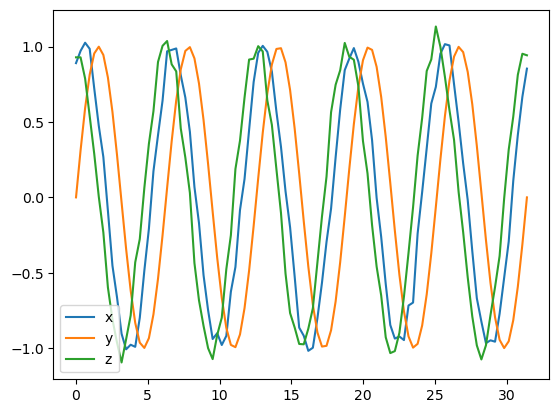

In [3]:
t,x,y,z = load_variables_sinusoidales(n=100,T=10*np.pi,lag=np.pi/3,noise=True,seed=42,cos=True)
data_dict = {'x': x,'y': y,'z': z}
df = pd.DataFrame(data_dict,index = t)
df.plot()

# Information, Entropy and Transfer Entropy:
Capturer les interdépendances causales à partir de donnée est un des défis majeur d'analyse de série temporelles non linéaire. On va d'abord voir les méthodes mise en places jusqu'a maintenant, leurs limites respectives et cas d'applications.

**Définition d'Entropie** :
`L'entropie de Shannon (1948)` est par défintion une mesure pour l'incertitude d'une variable aléatoire. 

Soit X VAD (variable aléatoire `discrète`). Pensons l'information en terme de probabilité. Un événement qui a de grande chance d'arriver ne contient pas beaucoup d'information (on sait qu'il arrive, l'événement ne transporte rien, l'entropie associée est nulle)

- L'entropie de X augmente avec le nombre de bits necessaire pour encoder une séquence de réalisations de X. 
- X doit être une VAD
$$
H(X) = - \sum_{x} p(x)\,\ln p(x),
$$
où p est la fonction de masse (fonction de probabilité $\mathbb{P}$)

Propriétés :
- H(X) > 0

[Rényi (1961)](http://l.academicdirect.org/Horticulture/GAs/Refs/Renyi_1961.pdf) généralise la notion d'entropie de Shannon (ou plutôt l'entropie de Shannon devient un cas particulier $\alpha \rightarrow 1$, comme Hartley Entropy cas particulier $\alpha \rightarrow 0$,  collision entropy $q=2$ ...). On défini une entropie d'ordre $\alpha$  qui mesure l'information transférée seulement par certaines parties des distributions sous-jacentes. Cela permet de se concentrer sur des événements marginaux comme des pics ou des sauts (très localisés) qui ont une forte importance.

Elle est défini par :
$$ 
H_{\alpha}(X) = \frac{1}{1-q} \log \left( \sum_{x} p_{\alpha}(x) \right)
$$
- $H_{\alpha} \geq 0$
- Pour $\alpha > 1$, $H_{\alpha}(X)$ dépend plus des probabilité des événements les plus probables 
- Pour $0 < \alpha < 1$, les événemtns plus marginaux ont maintenant un poids plus important.
- On dérive alors une autre Transfer Entropy : [Rényi Transfer Entropy (2012)](https://arxiv.org/abs/1106.5913)
## Calcul de l'entropie par discrétisation

Pour estimer l'entropie d'une série temporelle réelle $ (\{x_t\}) $ à partir d'un **histogramme** (binning), on procède comme suit :

1. **Discrétisation** : on découpe l'axe des valeurs en un nombre fini $B$ de catégories (bins).  
   - Pour chaque point $ (x_t) $, on identifie dans quel bin il tombe (entier $ (0 \le b < B) $.  
2. **Estimation de la loi de probabilité** : on compte la fréquence de chaque bin dans la série.  
   - Par exemple, $ p(b) = \frac{\text{nombre d'éléments dans le bin } b}{N} $, où  $N$ est la taille totale de l'échantillon.  
3. **Calcul de l'entropie (Shannon Entropy)** :  
$$
H(X) = - \sum_{b=0}^{B-1} p(b)\,\ln p(b),
$$
en ignorant les bins vides (où $p(b)=0$).

Cette méthode s'étend aussi aux **entropies conjointes** (avec 2 bins, 3 bins, etc.) en formant un histogramme multi-dimensionnel, et aux **entropies conditionnelles**.

---

### Mutual Information 
La **Mutual Information** (information mutuelle) $I(X;Y)$ entre deux variables $X$ et $Y$
` mesure combien la connaissance de X diminue l’incertitude sur Y` (et réciproquement car I symétrique)

Elle s’écrit dans le cas de deux variables :

$$
I(X; Y) \;=\; H(X) \;+\; H(Y) \;-\; H(X, Y).
$$
où $H(X, Y)$ est l'entropy conjointe de $(X,Y)$

En pratique, on estime la loi conjointe $\hat{p}(x,y)$ par un histogramme 2D, et les lois marginales $\hat{p}(x)$ et $\hat{p}(y)$ par des histogrammes 1D.

---

### Transfer Entropy ou 'Conditional Mutual Information' 
On remarque que la notion de Mutual Information ne permet pas de traiter le cas de la directionalité (car symétrique). La Mutual Information ne permet pas de distinguer si l'historique de X apporte une information interressante pour Y qui n'est pas déjà contenue dans l'historique de Y. Alors, il faut regarder une information mutuelle conditionnelle, qui traduira plutôt Si X apporte une information supplémentaire à celle déjà contenue dans l’historique de Y. En fait elle mesure `La quantité d'incertitude réduite sur les futures valeurs de Y d'après les valeurs observée de X, sachant qu'on a déjà des valeurs observée de  Y  ` 

La notion est introduite par [T. Schreiber (2000)](https://arxiv.org/pdf/nlin/0001042) et basé sur la divergence de Kullback-Leibler:

Soit:
- $Y^{(k)}_n \equiv \bigl(Y_{t_n}, Y_{t_{n-1}}, \dots, Y_{t_{n-k+1}}\bigr)$
- $X^{(l)}_n \equiv \bigl(X_{t_n}, X_{t_{n-1}}, \dots, X_{t_{n-l+1}}\bigr)$.

On défini alors la conditional mutual information (ou  **Shannon Transfer Entropy de $X_t$ vers $Y_t$**) :
$$
\begin{aligned}
T_{X \to Y}^{(k,l)} \;\equiv\; I\!\bigl(Y_{t_{n+1}} : X^{(l)}_n \,\bigm|\, Y^{(k)}_n\bigr)
&= H\bigl(Y_{t_{n+1}} : Y^{(k)}_n\bigr)
- H\bigl(Y_{t_{n+1}} : (X^{(l)}_n, Y^{(k)}_n)\bigr) \\
&= \sum_{\,y^{(k)}_n \in Y^{(k)}_n,\, x^{(l)}_n \in X^{(l)}_n} 
p\bigl(y_{t+1},\, y^{(k)}_n,\, x^{(l)}_n\bigr)\;
\log_{2}\!\Biggl[
\frac{\,p\bigl(y_{t+1}\mid y^{(k)}_n,\, x^{(l)}_n\bigr)\!}
{\;p\bigl(y_{t+1}\mid y^{(k)}_n\bigr)\!}
\Biggr].
\quad 
\end{aligned}
$$


Hyppothèse en amont: 
- Cela `suppose que X est une série temporelle stationnaire`(moyenne et variance constante, indépendante du temps) 
- Ignore les possibilité de dépendances conditionnelles entre les variables 

Propriétés:
- Pour deux processus stochastiques independant, alors l'entropie de transfer est nul. Rappel: `Un process stochastique est une famille de VA`
- Dans le cas non nulle, l'entropie de transfer mesure l'écart par rapport à l'indépendance des deux processus. 
- Entropie de transfer directionnelle : $T_{X \to Y} \neq T_{Y \to X}$ 
---

### Réinyi Transfer Entropy (RTE)
De la même manière qu'on défini $H_{\alpha}(X)$ l'entropie d'ordre $\alpha$ de $X$, on peut définir respectivement l'entropie conditionnelle d'ordre $\alpha$ et l'information mutuelle d'ordre $\alpha$: $H_{\alpha}(Y \mid X)$ et $I_{\alpha}(Y : X)$. 

On peut les exprimer explicitement comme suit:

$$
H_{\alpha}(Y \mid X)
= \frac{1}{1 - \alpha} \,\log_{2}\!
\Biggl(
  \frac{\displaystyle \sum_{x \in X} p^{\alpha}(x)}{\displaystyle \sum_{x \in X,\, y \in Y} p^{\alpha}(x, y)}
\Biggr),
$$

$$
I_{\alpha}(Y : X)
= \frac{1}{1 - \alpha} \,\log_{2}\!
\Biggl(
  \frac{\displaystyle \sum_{x \in X,\, y \in Y} p^{\alpha}(x)\,p^{\alpha}(y)}
       {\displaystyle \sum_{x \in X,\, y \in Y} p^{\alpha}(x, y)}
\Biggr).
$$
On exprime alors la Réinyi Transfer Entropy RTE, qui peut être interprété comme `le degré d'ignorance (ou d'incertitude)` sur $Y_{t_{n+1}}$ que les états passées $Y_{n}^{k}$ et $X_{n}^{l}$ permettre de résoudre, `au-delà du degré d'ignorance déjà levé` par le seul état passé $Y_{n}^{k}$ pris isolément.`:

$$
\begin{aligned}
T^{R}_{\alpha, X \to Y}(k, l) 
&= H_{\alpha}(Y_{t_{n+1}} \mid Y^{(k)}_n) - H_{\alpha}(Y_{t_{n+1}} \mid Y^{(k)}_n, X^{(l)}_n) \\
&= I_{\alpha}(Y_{t_{n+1}} : X^{(l)}_n \mid Y^{(k)}_n) \\
&= \frac{1}{\,1-\alpha\,}\;\log_{2}\!\Biggl(
\frac{
   \displaystyle \sum\limits_{y^{k}_n \in Y_{n}^{(k)}} \phi_{\alpha}(y^{k}_{n})p^{\alpha}(y_{n+1}|y_{n}^{k})
}{
   \displaystyle \sum\limits_{x^{l}_n \in X_{n}^{(l)},y^{k}_n \in Y_{n}^{(k)}} \phi_{\alpha}(y^{k}_{n},x^{l}_{n})p^{\alpha}\!\bigl(y_{n+1}\mid y_{n}^{(k)},\,x_{n}^{(l)}\bigr)
}
\Biggr)
\end{aligned}
$$

avec $\phi_{\alpha}$ `escort (ou zooming) distribution`tel que: 

$$
\phi_{\alpha}(x) = \frac{p^{\alpha}\bigl(x\bigr)}{\sum\limits_{x \in X} p^{\alpha}\!\bigl(x\bigr)} 
$$


Propriétés:
- RTE peut être négative
- `L'incertitude` sur le process de $Y_{t}$ est `d'autant plus grande que` l'on connait le passé d'autres variables: $H_{\alpha}(Y_{t_{n+1}} \mid Y^{(k)}_n) < H_{\alpha}(Y_{t_{n+1}} \mid Y^{(k)}_n,X^{(l)}_n) $ 
- Contrairement à la transfer entropy de Shannon, $T^{R}_{\alpha, X \to Y}(k, l) = 0$ n'implique pas forcément indépendance (mais vrai dans le cas Gaussian process).



---

### Effective Transfer Entropy (ETE)
Généralement, un ajustement est effectué sur la Transfer Entropy pour limiter les effets de 'petit sample', qui vont biaiser la Transfer Entropy.
[Marschinski & Kantz (2002)](https://link.springer.com/article/10.1140/epjb/e2002-00379-2) ont alors introduit l'Effective Transfer Entropy' (ETE) qui est la différence entre $T$ et $T$ utilisant une version 'shuffled' de X:
$$
ETE_{X \to Y}^{(k,l)} = T_{X \to Y}^{(k,l)} - T_{X_{shuffled} \to Y}^{(k,l)}
$$

L'idée est que le shuffling rend nulle les dépendance entre $X$ et $Y$, donc $T_{X_{shuffled} \to Y}^{(k,l)}$  converge vers 0 quand la taille du sample augmente. Mais où la taille n'est pas assez grande, cela permet de corriger le biais.
Une telle 'shuffled' conserves de nombreuses informations du signal (bien que cela détruit les 'relation de phases' du signal, i.e la structure temporelle et correlation non linéaire de la variable):
- la même variance
- la même moyenne
- la même fonction d'autocorrelation
- même 'spectre de puissance' ??

### Effective Rényi Transfer Entropy (ERTE)

$$
T^{(R,\text{eff})}_{\alpha;X \to Y}(m, l) \equiv T^{(R)}_{\alpha;X \to Y}(m, l) - T^{(R)}_{\alpha;X_{\text{shuffled}} \to Y}(m, l).
$$


### Transfer Entropy (3 variables)

Si on veut évaluer l’influence de **\(X\) et \(Z\)** sur \(Y\), on calcule la TE **multivariée** :

$$
\mathrm{TE}_{t}(\{X,Z\}\rightarrow Y) \;=\; I\bigl(\{X,Z\}_t;\;Y_{t+1}\;\bigm|\;Y_t\bigr),
$$
ce qui se généralise en formant un **histogramme multi-dimensionnel** \(\hat{p}(x_t, z_t, y_t, y_{t+1})\).

---

### Granger Causality 
L'idée principale de la Granger Causality est de comparer deux modèles, l'un avec uniquement une variable Y qui est celle que l'on souhaite prédire, l'autre avec la variable Y et une autre X. Puis on compare les prédiction pour savoir laquelle est la meilleur.

La 'Granger Causality' a valu un prix Nobel d'économie à Clive William John Granger (récompansant ses travaux sur l'analyse non linéaire de série temporelles). plutôt mal-nommé, Granger lui même considère que de nombreux 'mauvais papier' sont apparu à la suite de ses découvertes, et que 'Granger Predictability' pourrait être un terme plus adapté.

Supposons que l'on souhaite travailler sur la prédiction d'une variable Y. 
On propose d'abord de considérer un modèle `autoregressif`, avec une succession de $\tau$ lags:
$$
Y(t) = \sum\limits_{l=1}^{\tau}\alpha_{l}Y(t-l)+\epsilon_{1}(t)
$$
où $\epsilon$ est la variable d'erreur 
Ainsi qu'un modèle avec X et Y:
$$
Y(t) = \sum\limits_{l=1}^{\tau}\left(\alpha_{l}Y(t-l) \beta_{l}X(t-l)\right)+\epsilon_{2}(t)
$$
On considère que $\epsilon_{1}$ et $\epsilon_{2}$ ont une moyenne nulle et même variance $\sigma$.
Pour conclure si '$X$ Granger Cause $Y$', on fait un `F-test` entre les deux équations de modèles.


Limites: 
- Supposes que les séries temporelles sont stationnaires
- Initiallement développ" pour des équations linéaires. Dans le cas d'équations non linéiare l'expliquabilité n'est pas évidente, et les test statistiques moins compéhensibles. 

Etapes d'après (https://pablomflores.com/granger-causality/).:
1. Check Stationnarité:  On doit donc d'abord s'assurer que les séries temporelles sont stationnaire. On peut utiliser différents test:
    - Augmented DickeyFuller (ADF): si p<0.05, alors ts stationnaire `(Test implémenté dans granger.py)`
    - KPSS : si p>0.05, alors ts stationnaire
2. Correction de Stationnarité:  Si elles ne sont pas stationnaire, on doit les transformer  `(On utilise la méthode de différence première, qsue l'on re-itère autant de fois que nécessaire)`
3. Lags :  Une fois stationnaire, on choisi le bon nombre de lags pour la Granger Causality. On peut utiliser différentes méthodes:
    - BIC, AIC, FPE, HQIC ...
    - Choix des methodes:
        - **AIC (Akaike Information Criterion)** : pénalise les modèles avec un grand nombre de paramètres, évitant l'overfitting.
            - $AIC = 2k - 2\ln(L)$ ($L$ vraisemblance, $k$: nombre de paramètres libres$)
        - **BIC (Bayesian Information Criterion or Schwarz Information Criterion)** : un des critère les plus populaire. Pénalise d'autant plus le nombre de paramètres. AIC et AICc (cas petit échantillon) dérivent de théorie de l'information contrairement à BIC, et sont d'après certains préférable à BIC.
            - $BIC = -2\ln(L) +k\ln(N)$  ($N$: taille de l'échantillon)
        - **FPE (Final Prediction Error)** : 
        - **HQIC** : 
        
4. Analyse préliminaire `Vector AutoRegression` (VAR) :  Analyse multivariée pour identifier les relation entre les différentes variables 
5. Granger Causality : Parmi les combinaisons de variables étudiées, on sélectionne celles qui semblent bonne et on effectue une Granger Analysis dessus. 
---

## Approches Cas Non stationnaire: 

---

### Remarque

Dans tous les cas (entropie, mutual information, transfer entropy), **la logique de “binning” et de comptage** est la même :  
- On associe chaque échantillon à un bin (ou une combinaison de bins pour plusieurs variables).  
- On estime **empiriquement** $p(\cdot)$ à partir du nombre de points dans chaque bin.  
- On applique les formules $\sum p \,\ln(\dots)$ pour estimer l'entropie ou l'information mutuelle.
- On a généralement $k = l$, et dans le cas de Markov Process, $k=l=1$


Considérons à présent deux séries temporelles (par exemple, deux séries boursières) représentées par des variables aléatoires stochastiques $X_t$ et $Y_t$. Supposons de plus que les pas de temps (p. ex., les « ticks » de marché) soient discrets, avec un pas $\tau$, et que $t_n = t_0 + n\tau$, où $t_0$ est un temps de référence. Pour des raisons pratiques, il est également utile de considérer que $X_t$ et $Y_t$ sont des processus de Markov en temps discret d’ordres $k$ et $l$ respectivement.

Nous souhaitons maintenant déterminer quelle information est gagnée sur $X_{t_{n+1}}$ en observant $Y_t$ jusqu’au temps $t_n$. À cette fin, nous introduisons le processus commun $\bigl(X_{t_n}, X_{t_{n-1}}, \dots, X_{t_{n-k+1}}\bigr)$, noté $X^{(k)}_n$, et de même, nous définissons le processus commun $Y^{(l)}_n \equiv \bigl(Y_{t_n}, Y_{t_{n-1}}, \dots, Y_{t_{n-l+1}}\bigr)$.

On défini alors la conditional mutual information (ou  **Shannon Transfer Entropy de $Y_t$ vers $X_t$**) 

$$
I\!\bigl(X_{t_{n+1}} : Y^{(l)}_n \,\bigm|\, X^{(k)}_n\bigr)
= H\bigl(X_{t_{n+1}} : X^{(k)}_n\bigr)
- H\bigl(X_{t_{n+1}} : (Y^{(l)}_n, X^{(k)}_n)\bigr)
= \sum_{\,x^{(k)}_n \in X^{(k)}_n,\, y^{(l)}_n \in Y^{(l)}_n} 
p\bigl(x_{n+1},\, x^{(k)}_n,\, y^{(l)}_n\bigr)\;
\log_{2}\!\Biggl[
\frac{\,p\bigl(x_{n+1}\mid x^{(k)}_n,\, y^{(l)}_n\bigr)\!}
{\;p\bigl(x_{n+1}\mid x^{(k)}_n\bigr)\!}
\Biggr].
\quad 
$$

On la note généralement :

$$
T_{Y \to X}^{(k,l)} \;\equiv\; I\!\bigl(X_{t_{n+1}} : Y^{(l)}_n \,\bigm|\, X^{(k)}_n\bigr).
$$


In [4]:
nb_bins = 10
window_size = 6

tsi = TimeSeriesInfo(nb_bins=nb_bins)

## Calcul direct de l'entropie: 

#### 'Digitalisation du signal':
On utilise un histogramme des valeurs pour tout discrétiser.

<AxesSubplot:>

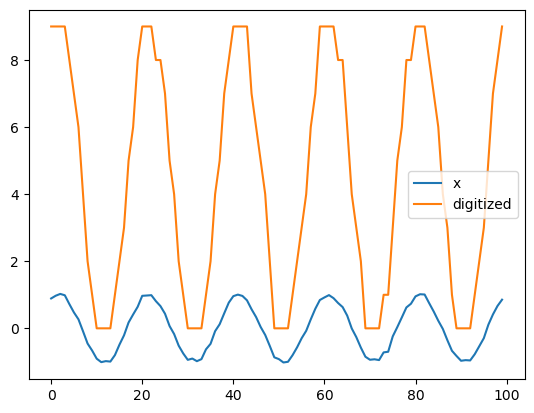

In [7]:
nb_bins = 10
hist, bin_edges = np.histogram(x, bins=nb_bins)
digitized = np.digitize(x, bin_edges[1:-1])
pd.DataFrame(dict(x=x,digitized=digitized)).plot()

In [9]:
mi_xy = tsi.sliding_window_mutual_info(x, y, window_size=window_size)  # Exemple 1 : I(X;Y) sur des fenêtres glissantes
te_xy = tsi.sliding_window_transfer_entropy(x, y, window_size=window_size)  # Exemple 2 : Transfer Entropy (X->Y) ~ I(X_t; Y_{t+1} | Y_t)
te_xzy = tsi.sliding_window_multi_transfer_entropy([x, z], y, window_size=window_size) # Exemple 3 : Transfer Entropy multi-séries {X, Z} -> Y

In [10]:
source = ColumnDataSource(data={'Time':t[window_size-1:],'explainable':x[window_size-1:],'target':y[window_size-1:],'MI':mi_xy})
p1 = visualize_TE(source,time = 'Time',explainable = 'explainable', target = 'target',TE = 'MI',title= 'MI(X,Y) (Mutual Information) plotted on X')

source = ColumnDataSource(data={'Time':t[window_size:],'explainable':x[window_size:],'target':y[window_size:],'TE':te_xy})
p2 =visualize_TE(source,time = 'Time',explainable = 'explainable', target = 'target',TE = 'TE',title='TE(X -> Y) plotted on X (explainable variable)')

source = ColumnDataSource(data={'Time':t[window_size:],'explainable1':x[window_size:],'explainable2':z[window_size:],'target':y[window_size:],'TE':te_xzy})
visualize_TE(source,time = 'Time',explainable = ['explainable1','explainable2'], target = 'target',TE = 'TE',title='TE(X,Z -> Y) plotted on Z (explainable variable)')


Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Figure(id='1295', ...)

In [ ]:

##########################
# 1) Génération de deux exemples
##########################

def generate_example_1(n=100):
    """
    Exemple trivial (périodique) : 
      X = sin, Y = cos (même fréquence, décalage), Z = un bruit random.
    """
    t = np.arange(n)
    X = np.sin(2 * np.pi * t / 20)  # période ~20
    Y = np.cos(2 * np.pi * t / 20)  # même période, phase décalée
    Z = 0.3 * np.random.randn(n)    # bruit (pas ou très peu lié)
    return t, X, Y, Z

def generate_example_2(n=200):
    """
    Exemple 2 (saisonnalité + bruit) :
      X = 0.5 cos(2π t/24) + bruit
      Y = 0.5 cos(2π (t+3)/24) + léger bruit (décalage ~3)
      Z = 0.5 cos(2π (t+10)/24) + bruit (moins corrélé à Y).
    """
    t = np.arange(n)
    X = 0.5 * np.cos(2 * np.pi * t / 24) + 0.1 * np.random.randn(n)
    Y = 0.5 * np.cos(2 * np.pi * (t + 3) / 24) + 0.1 * np.random.randn(n)
    Z = 0.5 * np.cos(2 * np.pi * (t + 10) / 24) + 0.1 * np.random.randn(n)
    return t, X, Y, Z


##########################
# 2) Fonctions de démo Bokeh
##########################



# Estimateur à Noyau 
## Estimation de la Transfer Entropy via la méthode KSGE

La **méthode KSGE** (extension de l’estimateur KSG initialement proposé par Kraskov, Stögbauer et Grassberger) vise à **estimer la Transfer Entropy (TE)** dans le cas de **variables continues** à l’aide d’une approche basée sur les plus proches voisins (k-nearest neighbors).

### Définition de la Transfer Entropy

Pour deux processus aléatoires \(X\) et \(Y\), la Transfer Entropy (simplifiée à un pas) s’écrit souvent comme :

$$
\mathrm{TE}_{X \rightarrow Y} = \sum_{x_t, y_t, x_{t+1}} p(x_{t+1}, x_t, y_t)\; \ln \!\biggl[\frac{p(x_{t+1} \mid x_t, y_t)}{p(x_{t+1} \mid x_t)}\biggr].
$$

Ici,
- \(x_t\) et \(x_{t+1}\) désignent deux instants successifs de la variable \(X\),
- \(y_t\) désigne l’instant courant de la variable \(Y\),
- \(p(\cdot)\) et \(p(\cdot|\cdot)\) désignent les densités conjointes et conditionnelles.

### Principe de l’estimation KSGE

1. **Représentation des échantillons** : On considère chaque triplet \((x_{t+1}, x_t, y_t)\) (ou quadruplet si on inclut un historique plus grand).
2. **Recherche de k-plus proches voisins** : Pour chaque point dans l’espace (ici, l’espace formé par \((x_t,y_t)\) ou \((x_{t+1}, x_t, y_t)\) suivant le terme à estimer), on recherche ses k-plus proches voisins. 
3. **Estimations des densités** : Les distances calculées servent à approximer les densités jointes et conditionnelles.
4. **Calcul de la TE** : À partir de ces estimations, on obtient une approximation de l’information mutuelle conditionnelle \(\mathrm{I}(X_{t+1};Y_t\mid X_t)\), qui correspond à la Transfer Entropy.

Le principal avantage de la méthode KSGE est qu’elle **ne requiert pas** de **discrétisation** explicite des variables et qu’elle s’adapte bien à des données continues, potentiellement multidimensionnelles.

Pour plus de détails, on peut se référer aux travaux originels de **Kraskov, Stögbauer et Grassberger (2004)** sur l’estimation de l’information mutuelle par méthode à k-plus proches voisins, ainsi qu’à leurs extensions dédiées à la Transfer Entropy.


In [ ]:
# 2) Choix des lags : ex. X(t), X(t-1), Z(t), Y(t) en condition => on veut TE(X,Z -> Y(t+1) | Y(t))
#    => On inclut y(t) dans la condition => lags_dict['y'] = [0]
#    => On inclut x(t) et x(t-1) => lags_dict['x'] = [0,1]
#    => On inclut z(t) => lags_dict['z'] = [0]
lags_dict = {
    'x': [0, 1],
    'z': [0],
    'y': [0]  # Y(t) en condition
}

# 3) Instancier un estimateur KSG => version non-simplifiée
ksg_est = KSGEstimator(k=5, simplified=False)

# 4) Créer le calculateur TE
te_calc = TimeSeriesTECalculator(estimator=ksg_est)

# 5) Calculer TE dans des fenêtres glissantes
#    TE({X(t),X(t-1),Z(t)} -> Y(t+1) | Y(t))
#    window_size=10
te_values_ksg = te_calc.sliding_window_te(
    data_dict=data_dict,
    lags_dict=lags_dict,
    target_var='y',
    target_offset=1,    # Y(t+1)
    window_size=10
)
print("KSG1 TE({X,Z}->Y):", te_values_ksg)

# 6) Idem version simplifiée KSG
ksg_est_simpl = KSGEstimator(k=5, simplified=True)
te_calc_simpl = TimeSeriesTECalculator(estimator=ksg_est_simpl)
te_values_simpl = te_calc_simpl.sliding_window_te(
    data_dict=data_dict,
    lags_dict=lags_dict,
    target_var='y',
    target_offset=1,
    window_size=10
)
print("KSG simplifié TE({X,Z}->Y):", te_values_simpl)

# 7) KDE
kde_est = KDEEstimator(bandwidth=0.3)
te_calc_kde = TimeSeriesTECalculator(estimator=kde_est)
te_values_kde = te_calc_kde.sliding_window_te(
    data_dict=data_dict,
    lags_dict=lags_dict,
    target_var='y',
    target_offset=1,
    window_size=10
)
print("KDE TE({X,Z}->Y):", te_values_kde)

KSG1 TE({X,Z}->Y): [-0.4940915761200504, -0.6186732984758714, -0.27144872866025116, -0.2741176450956444, -0.37592975182260124, -0.45435919491586185, -0.277963657950552, -0.557887808090221, -0.6552760857105757, -0.4218223131001504, -0.564660958905578, -0.6165406658476011, -0.6488518995815058, -0.5515018299956838, -0.424696910232514, -0.5753341405147507, -0.5485338437294496, -0.4153680040776824, -0.6886693365429735, -0.6327128849109209, -0.7213444653685763, -0.49210279208899843, -0.5248217901142953, -0.45413604969884513, -0.6684524514810706, -0.8309376448847872, -0.8272429362899694, -0.9047564440682758, -0.9053903921106845, -0.663879508922697, -0.631805009636967, -0.6094198931755757, -0.5445509389967407, -0.3291448228511038, -0.4779762095123312, -0.5490709180507476, -0.5225607810101323, -0.4593559020423925, -0.6294497861146024, -0.5177325606352223, -0.5467002914829426, -0.5435564056056661, -0.6157119296393314, -0.5430026002280874, -0.4061602615658946, -0.4807539397906839, -0.601769573953

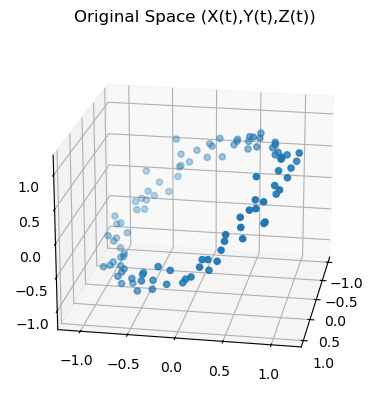

[X-only attracteur] Corrélation CCM(X->Y) = 1.000


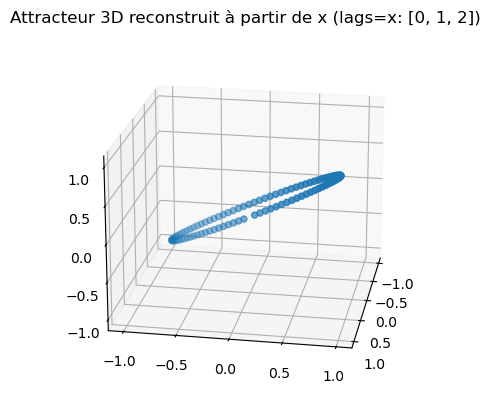

[X-only attracteur] Corrélation CCM(X->Y) = 1.000


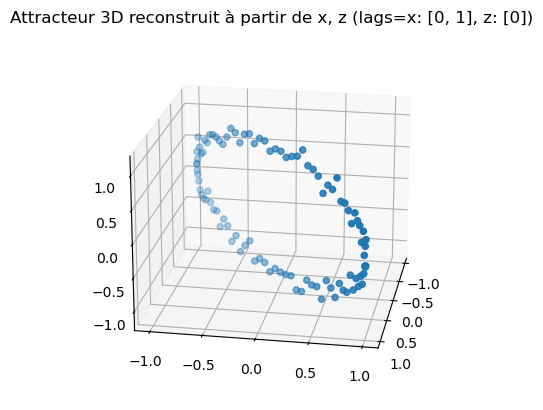

In [5]:
ccm_plot_reconstruction(np.array([x,y,z]).transpose())

data_dict = {'x': x, 'y': y, 'z': z}

lags = {'x': [0, 1, 2]}
y_est,embedding = get_embedding_and_reconstruct(data_dict,target_variable='y',lags=lags,k=4,use_weighted_mean=True)
ccm_plot_reconstruction(embedding,lags)


lags = {'x': [0, 1], 'z': [0]}
y_est,embedding = get_embedding_and_reconstruct(data_dict,target_variable='y',lags=lags,k=4,use_weighted_mean=True)
ccm_plot_reconstruction(embedding,lags)

## Time Serie avec des événements spécifiques présent à des moments particuliers:

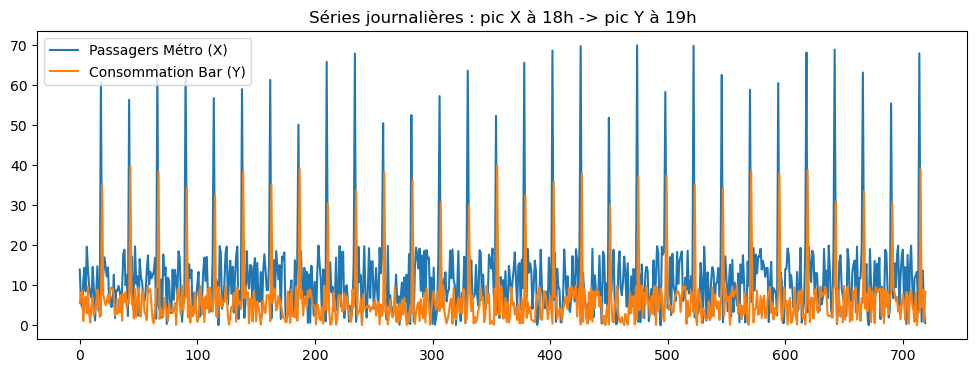

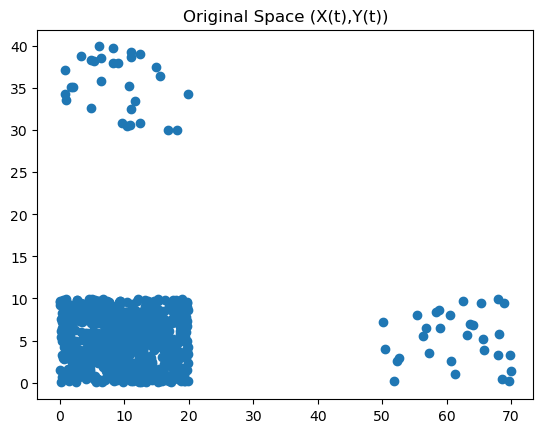

[X-only attracteur] Corrélation CCM(X->Y) = 1.000


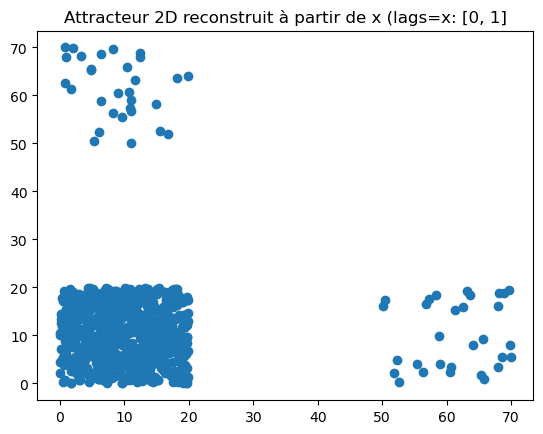

In [6]:
X_metro,Y_alcool = load_variables_subway_bar()
plot_subway_bar(X_metro,Y_alcool)

ccm_plot_reconstruction(np.array([X_metro,Y_alcool]).transpose())

data_dict = {'x': X_metro, 'y': Y_alcool}

lags = {'x': [0, 1]}
y_est,embedding = get_embedding_and_reconstruct(data_dict,target_variable='y',lags=lags,k=4,use_weighted_mean=True)
ccm_plot_reconstruction(embedding,lags)

## Moments identifié, on focus entre 16 et 20h: 

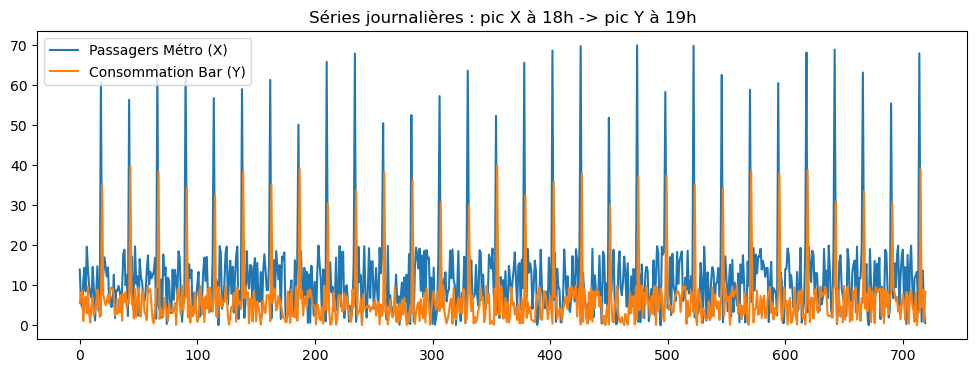

Corrélation CCM(X->Y) (sans décalage explicite) = 1.000
Corrélation CCM(X décalé 1h -> Y) = 1.000
La corrélation n'augmente pas beaucoup : le lien partiel est peut-être masqué par le bruit global.
CCM(X->Y) juste sur la tranche 16h..20h: corrélation = 1.000


In [ ]:
###############################
# Test CCM sur la série brute
###############################
from sklearn.neighbors import NearestNeighbors

def ccm_basic(cause: np.ndarray, effect: np.ndarray, E=2, tau=1, k=4):
    """
    CCM simplifié, on ne reconstruit qu'avec la série cause,
    dimension E, retard tau, k voisins.
    """
    n = len(cause)
    start_idx = (E-1)*tau
    M_points = []
    valid_t = []
    for t in range(start_idx, n):
        coords = [cause[t - i*tau] for i in range(E)]
        M_points.append(coords)
        valid_t.append(t)
    M_points = np.array(M_points)
    valid_t = np.array(valid_t)

    nbrs = NearestNeighbors(n_neighbors=k).fit(M_points)
    y_true = []
    y_est = []
    for i, v in enumerate(M_points):
        dist, idxs = nbrs.kneighbors(v.reshape(1,-1))
        d = dist[0]
        d = np.where(d<1e-12, 1e-12, d)
        w = 1./d
        w /= w.sum()
        neighbors_t = valid_t[idxs[0]]
        val_neigh = effect[neighbors_t]
        val_hat = np.sum(val_neigh * w)
        y_true.append(effect[valid_t[i]])
        y_est.append(val_hat)
    return np.array(y_true), np.array(y_est)



def correlation(x, y):
    return np.corrcoef(x, y)[0,1]

# 1) Sans décalage
Ytrue, Yest = ccm_basic(X_metro, Y_alcool, E=2, tau=1, k=5)
rho_xy = correlation(Ytrue, Yest)
print(f"Corrélation CCM(X->Y) (sans décalage explicite) = {rho_xy:.3f}")

# 2) Décalage d'une heure dans X ?
#    On peut manuellement décaler X de 1h : X_shifted[t] = X[t-1].
#    Ensuite faire CCM(X_shifted->Y) => pour voir si c'est plus corrélé
X_shifted = np.roll(X_metro, 1)  # Décalage circulaire => on pourrait mettre un 0 sur la 1ère case si besoin
Ytrue_shift, Yest_shift = ccm_basic(X_shifted, Y_alcool, E=2, tau=1, k=5)
rho_xshift_y = correlation(Ytrue_shift, Yest_shift)
print(f"Corrélation CCM(X décalé 1h -> Y) = {rho_xshift_y:.3f}")

# Interprétation
if rho_xshift_y > rho_xy + 0.05:  # Seuil arbitraire
    print("On observe qu'avec le décalage de 1h, la corrélation est plus forte, suggérant un lien à 1h de retard.")
else:
    print("La corrélation n'augmente pas beaucoup : le lien partiel est peut-être masqué par le bruit global.")


###############################
# Astuce : segmenter la journée
###############################
# Si vous suspectez que la causalité n'existe qu'autour de 18h->19h, vous pouvez
# extraire la fenêtre [16h..20h] chaque jour et concaténer, etc.
# Ou faire CCM sur cette sous-série. 
#
# Exemple rapide : on regarde seulement la plage 16h..20h sur tous les jours.
window_data_x = []
window_data_y = []
for d in range(days):
    start = d * hours_per_day
    sub_x = X_metro[start+16 : start+21]  # 16h..20h (5 points)
    sub_y = Y_alcool[start+16 : start+21]
    window_data_x.append(sub_x)
    window_data_y.append(sub_y)
window_data_x = np.concatenate(window_data_x)  # shape (days*5,)
window_data_y = np.concatenate(window_data_y)

Ytrue_w, Yest_w = ccm_basic(window_data_x, window_data_y, E=2, tau=1, k=4)
rho_window = correlation(Ytrue_w, Yest_w)
print(f"CCM(X->Y) juste sur la tranche 16h..20h: corrélation = {rho_window:.3f}")



## Lorentz variables: 
Exemple avec le system de Lorentz semi-chaotique

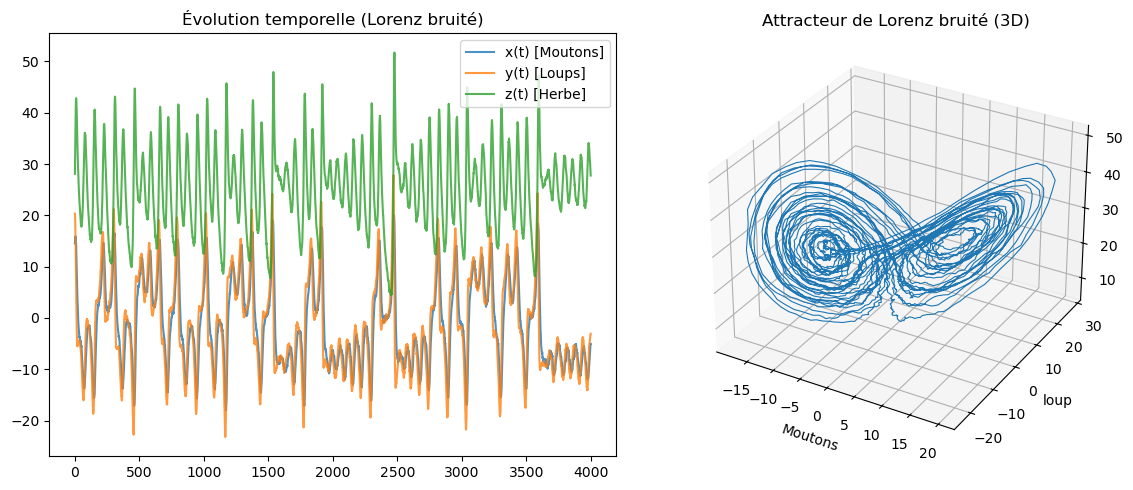

In [ ]:
x_mouton,y_loup,z_herbe = load_variables_lorenz()
plot_lorenz(x_mouton,y_loup,z_herbe)


[X-only attracteur] Corrélation CCM(X->Y) = 1.000


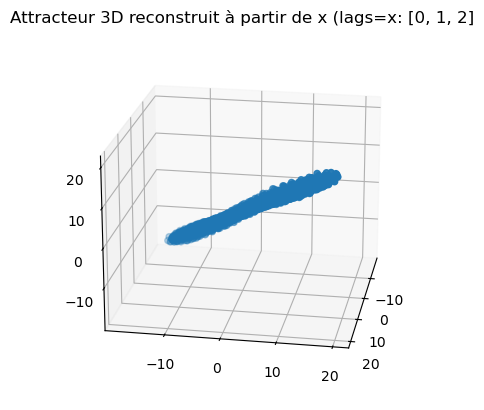

[X-only attracteur] Corrélation CCM(X->Y) = 1.000


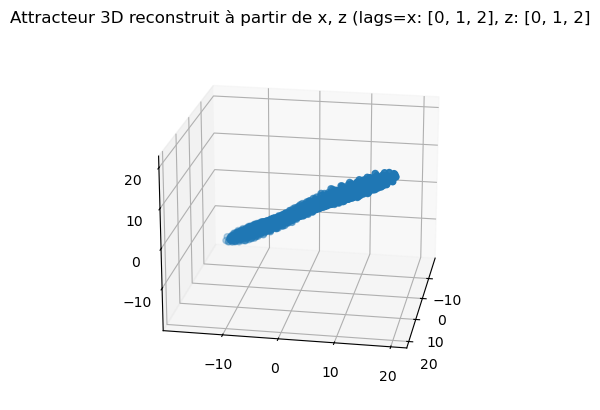

In [ ]:
data_dict = {'x': x_mouton, 'y': y_loup, 'z': z_herbe}
         
            
# lags :  3 composantes sur x => embedding dimension=3
# pas de lags pour y ni y => on ne les utilisent pas dans l'attracteur
lags = {'x': [0, 1, 2]}
y_est,embedding = get_embedding_and_reconstruct(data_dict,target_variable='y',lags =lags, k=4,use_weighted_mean=True)
plot_reconstruction(embedding,lags)
    

lags = {'x': [0, 1, 2],'z': [0,1,2]}
y_est,embedding = get_embedding_and_reconstruct(data_dict,target_variable='y',lags=lags,k=4,use_weighted_mean=True)
plot_reconstruction(embedding,lags)

'x: [0, 1, 2]'

In [ ]:
x_mouton,y_loup,z_herbe
# Test : CCM(Loups->Moutons)
E_dim = 3
tau_lag = 2
k_nn = 6
y_true, y_est = 





ccm_reconstruct(y_loup, x_mouton,
                                E=E_dim, tau=tau_lag, k=k_nn)
r_loups_moutons = correlation_coefficient(y_true, y_est)
print(f"Corrélation CCM(Loups->Moutons) = {r_loups_moutons:.3f}")

# Test : CCM(Moutons->Loups)
y_true2, y_est2 = ccm_reconstruct(x_mouton, y_loup,
                                  E=E_dim, tau=tau_lag, k=k_nn)

r_moutons_loups = correlation_coefficient(y_true2, y_est2)
print(f"Corrélation CCM(Moutons->Loups) = {r_moutons_loups:.3f}")

# Idem si vous voulez tester Herbe -> Moutons, etc.

plt.figure()
plt.plot(y_true[:200], label="Moutons (vrai)", alpha=0.7)
plt.plot(y_est[:200], label="Moutons (estimé via CCM Loups->Moutons)", alpha=0.7)
plt.title("Extrait reconstruction CCM(Loups->Moutons)")
plt.legend()
plt.show()

ccm_reconstruct_multivariate(embedding=emb_xz,
                                                    valid_time=valid_t_xz,
                                                    effect_series=y,
                                                    k=4,
                                                    use_weighted_mean=True)

    # ----------------------------------------------------
    # 4) Exemple d'analyse (CCM, etc.)
    # ----------------------------------------------------
    # Vous pouvez maintenant réutiliser votre code CCM, e.g.:
    #   ccm_reconstruct(x_noisy, y_noisy, E=3, tau=1, k=6)
    # pour voir la "causalité" X->Y.
    # Les résultats seront moins "parfaits" qu'en l'absence de bruit.

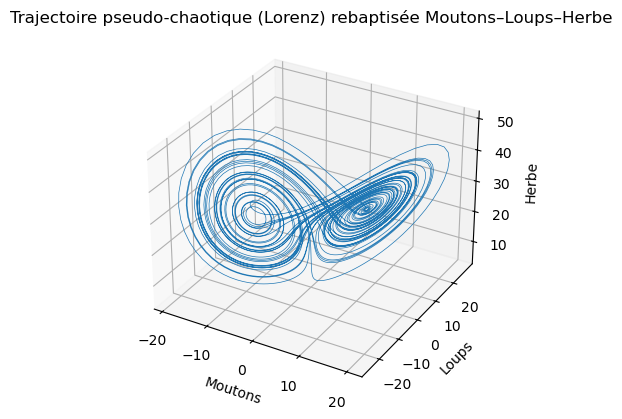

Corrélation CCM(Loups->Moutons) = 1.000
Corrélation CCM(Moutons->Loups) = 1.000


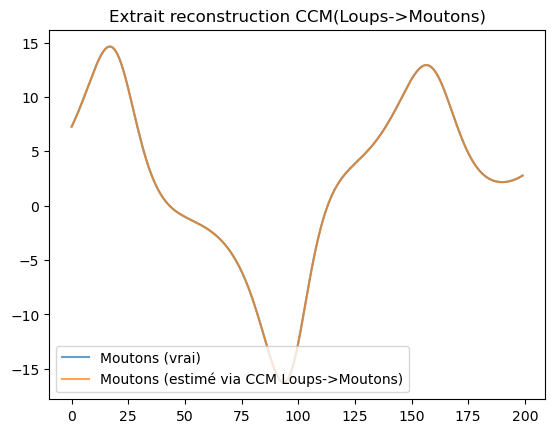

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from typing import Tuple

#####################
# 1) Système type Lorenz
#####################
def lorenz_system(state, sigma=10.0, rho=28.0, beta=8/3):
    """
    Équation de Lorenz :
    dx/dt = sigma*(y - x)
    dy/dt = x*(rho - z) - y
    dz/dt = x*y - beta*z
    """
    x, y, z = state
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return np.array([dx, dy, dz])

def simulate_lorenz(initial_state: np.ndarray,
                    dt: float = 0.01,
                    steps: int = 10000) -> np.ndarray:
    """
    Intégration d'Euler simple pour le système de Lorenz.
    Retourne un tableau (steps, 3) avec la trajectoire [x(t), y(t), z(t)].
    """
    traj = np.zeros((steps, 3))
    traj[0] = initial_state
    for i in range(1, steps):
        deriv = lorenz_system(traj[i-1])
        traj[i] = traj[i-1] + dt * deriv
    return traj

#####################
# 2) Génération des données "Moutons, Loups, Herbe"
#####################
np.random.seed(42)
initial_state = np.array([5.0, 5.0, 5.0])  # point de départ
data_lorenz = simulate_lorenz(initial_state, dt=0.01, steps=6000)
# Tronquons un peu le début pour éviter les transitoires
data_lorenz = data_lorenz[1000:]  # shape (5000, 3)

# On renomme : Moutons = X, Loups = Y, Herbe = Z
Moutons = data_lorenz[:, 0]
Loups = data_lorenz[:, 1]
Herbe = data_lorenz[:, 2]

#####################
# 3) Affichage 3D : "Papillon"
#####################
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(Moutons, Loups, Herbe, lw=0.5)
ax.set_xlabel("Moutons")
ax.set_ylabel("Loups")
ax.set_zlabel("Herbe")
ax.set_title("Trajectoire pseudo-chaotique (Lorenz) rebaptisée Moutons–Loups–Herbe")
plt.show()

#####################
# 4) Petit test CCM
#####################

# (a) On échantillonne la fin de la trajectoire (par ex. 1000 points) pour avoir la série
M = 1000
Moutons_sample = Moutons[-M:]
Loups_sample = Loups[-M:]
Herbe_sample = Herbe[-M:]

# (b) On applique CCM => vous pouvez réutiliser votre fonction ccm_reconstruct_multivariate
#     ou ccm_reconstruct mono-série. Ex. : Loups -> Moutons
#     On donne juste un squelette illustratif (simplifié) :

from sklearn.neighbors import NearestNeighbors

def ccm_reconstruct(cause_series: np.ndarray,
                    effect_series: np.ndarray,
                    E: int = 3,
                    tau: int = 1,
                    k: int = 5) -> Tuple[np.ndarray, np.ndarray]:
    """
    CCM simple, monovarié. Reconstruit effect_series à partir de l'attracteur de cause_series.
    """
    N = len(cause_series)
    start_index = (E - 1) * tau
    # Attracteur
    M_points = []
    valid_t = []
    for t in range(start_index, N):
        coords = [cause_series[t - i*tau] for i in range(E)]
        M_points.append(coords)
        valid_t.append(t)
    M_points = np.array(M_points)
    valid_t = np.array(valid_t)

    # k-NN
    nbrs = NearestNeighbors(n_neighbors=k).fit(M_points)
    y_pred = []
    y_true = []
    for i, mp in enumerate(M_points):
        dist, idxs = nbrs.kneighbors(mp.reshape(1, -1))
        # Weighted average
        d = dist[0]
        d = np.where(d<1e-12, 1e-12, d)
        w = 1/d
        w /= w.sum()
        neighbors_t = valid_t[idxs[0]]
        val_neighbors = effect_series[neighbors_t]
        val_est = np.sum(val_neighbors * w)
        y_pred.append(val_est)
        # Valeur réelle
        t_i = valid_t[i]
        y_true.append(effect_series[t_i])
    return np.array(y_true), np.array(y_pred)

def corr(x, y):
    return np.corrcoef(x, y)[0, 1]


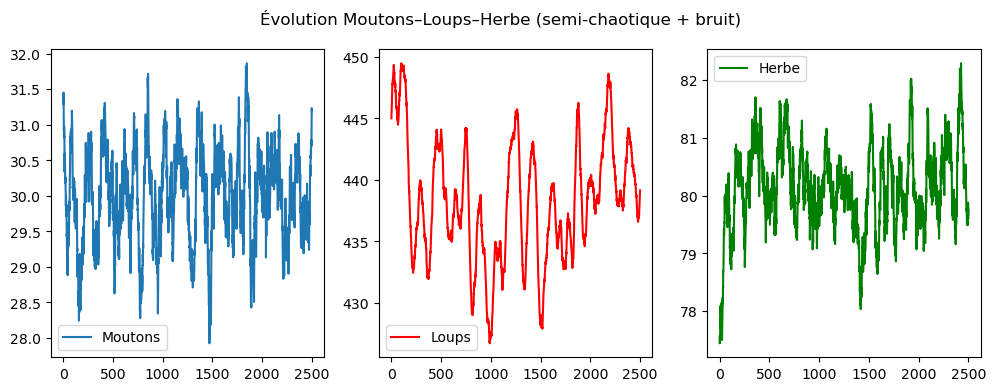

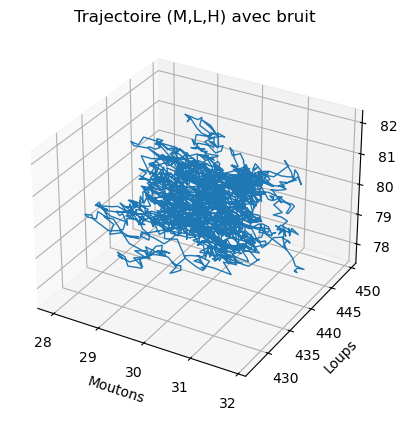

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def ddt_moutons(m, l, h, params):
    """
    dM/dt pour les moutons, avec bruit
    """
    rM, KM, alphaML, alphaMH = params['rM'], params['KM'], params['alphaML'], params['alphaMH']
    growth_logistic = rM * m * (1 - m/KM)
    loss_predation = - alphaML * m * l
    gain_from_herbe = alphaMH * m * h
    return growth_logistic + loss_predation + gain_from_herbe

def ddt_loups(m, l, params):
    """
    dL/dt pour les loups, avec bruit
    """
    rL, alphaLM = params['rL'], params['alphaLM']
    # -rL*l => mortalité
    # + alphaLM * m * l => gain si proies (moutons)
    return -rL*l + alphaLM*m*l

def ddt_herbe(m, h, params):
    """
    dH/dt pour l'herbe
    """
    rH, KH, alphaHM = params['rH'], params['KH'], params['alphaHM']
    growth_logistic = rH * h * (1 - h/KH)
    loss_browse = - alphaHM * h * m
    return growth_logistic + loss_browse

def simulate_mlh(m0, l0, h0, dt, steps, params, noise_std=0.01):
    """
    Simulation d'Euler simple du système Moutons, Loups, Herbe avec bruit.
    :param m0, l0, h0: conditions initiales
    :param dt: pas de temps
    :param steps: nb d'itérations
    :param params: dict des paramètres
    :param noise_std: écart-type du bruit (Gaussien) ajouté à dM, dL, dH
    :return: arrays M, L, H shape (steps,)
    """
    M = np.zeros(steps)
    L = np.zeros(steps)
    H = np.zeros(steps)
    M[0] = m0
    L[0] = l0
    H[0] = h0

    for i in range(1, steps):
        m = M[i-1]
        l = L[i-1]
        h = H[i-1]

        dm = ddt_moutons(m, l, h, params) * dt
        dl = ddt_loups(m, l, params) * dt
        dh = ddt_herbe(m, h, params) * dt

        # Ajout de bruit
        dm += np.random.normal(0, noise_std)
        dl += np.random.normal(0, noise_std)
        dh += np.random.normal(0, noise_std)

        M[i] = max(0.0, m + dm)  # on évite les valeurs négatives
        L[i] = max(0.0, l + dl)
        H[i] = max(0.0, h + dh)

    return M, L, H

if __name__=="__main__":
    # Paramètres du système
    params = {
        'rM': 0.5,  # croissance moutons
        'KM': 50.0, # capacité logistique moutons
        'alphaML': 0.001, # impact loups sur moutons
        'alphaMH': 0.003, # gain si + herbe
        'rL': 0.15,  # mortalité loups
        'alphaLM': 0.005, # gain loups si + moutons
        'rH': 0.3,  # croissance herbe
        'KH': 100.0, # capacité herbe
        'alphaHM': 0.002 # broutage mouton sur herbe
    }

    # Conditions initiales
    m0 = 10.0
    l0 = 5.0
    h0 = 30.0

    # Simulation
    dt = 0.1
    steps = 3000
    noise_std = 0.15  # bruit un peu significatif
    M, L, H = simulate_mlh(m0, l0, h0, dt, steps, params, noise_std=noise_std)

    # On tronque un certain nombre de pas pour enlever le transitoire
    skip = 500
    M = M[skip:]
    L = L[skip:]
    H = H[skip:]

    # Affichage
    fig = plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.plot(M, label="Moutons")
    plt.legend()

    plt.subplot(1,3,2)
    plt.plot(L, 'r', label="Loups")
    plt.legend()

    plt.subplot(1,3,3)
    plt.plot(H, 'g', label="Herbe")
    plt.legend()
    plt.suptitle("Évolution Moutons–Loups–Herbe (semi-chaotique + bruit)")
    plt.show()

    # Affichage 3D
    from mpl_toolkits.mplot3d import Axes3D
    fig3d = plt.figure()
    ax3d = fig3d.add_subplot(projection='3d')
    ax3d.plot(M, L, H, lw=1.0)
    ax3d.set_xlabel("Moutons")
    ax3d.set_ylabel("Loups")
    ax3d.set_zlabel("Herbe")
    ax3d.set_title("Trajectoire (M,L,H) avec bruit")
    plt.show()

    # A ce stade, on peut :
    #  - Appliquer un CCM(M->L), CCM(L->M), CCM(H->M), etc.
    #  - Observer que le bruit rend la reconstruction moins parfaite.


In [ ]:
from jupyter_ipynb.Entropy_and_information.CCM import ccm_reconstruct,correlation_coefficient
import matplotlib.pyplot as plt
# ---------------------------
# 2) Graphique 3D (X,Y,Z) original
# ---------------------------
# Plot de l'espace "réel" (x(t), y(t), z(t)) 
fig1 = plt.figure()
ax1 = fig1.add_subplot(projection='3d')
ax1.scatter(x, y, z)
ax1.set_title("Espace original : (X(t), Y(t), Z(t))")
plt.show()

# ---------------------------
# 3) Reconstruction d'attracteur en 3D à partir de X(t)
# ---------------------------
# Prenons E=3, tau=2 pour l'illustration
E = 3
tau = 2
N = len(x)
start_index = (E - 1)*tau
embedding = []
for i in range(start_index, N):
    coords = [x[i - e*tau] for e in range(E)]
    embedding.append(coords)
embedding = np.array(embedding)  # shape (N - start_index, 3)

# Plot 3D de l'attracteur reconstruit
fig2 = plt.figure()
ax2 = fig2.add_subplot(projection='3d')
ax2.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2])
ax2.set_title("Attracteur reconstruit à partir de X(t), E=3, tau=2")
plt.show()

# ---------------------------
# 4) Convergent Cross Mapping: X -> Y
# ---------------------------
# Paramètres de CCM
ccm_dim = 3
ccm_tau = 1
ccm_k = 4

# On obtient y_true, y_est
y_true, y_est = ccm_reconstruct(
    cause_series=x,
    effect_series=y,
    E=ccm_dim,
    tau=ccm_tau,
    k=ccm_k
)

# Corrélation
rho = correlation_coefficient(y_true, y_est)
print(f"Corrélation CCM (X -> Y) = {rho:.3f}")

# Interprétation du signe
if rho > 0.1:  # Seuil arbitraire
    print("CCM suggère que X a une influence positive sur Y (corrélation > 0).")
else:
    print("Aucune influence notable détectée de X vers Y (corrélation faible ou nulle).")

# ---------------------------
# 5) Convergent Cross Mapping: Y -> X (test inverse)
# ---------------------------
x_true, x_est = ccm_reconstruct(
    cause_series=y,
    effect_series=x,
    E=ccm_dim,
    tau=ccm_tau,
    k=ccm_k
)

# Plot 3D de l'attracteur reconstruit
fig2 = plt.figure()
ax2 = fig2.add_subplot(projection='3d')
ax2.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2])
ax2.set_title("Attracteur reconstruit à partir de X(t), E=3, tau=2")
plt.show()

rho_yx = correlation_coefficient(x_true, x_est)
print(f"Corrélation CCM (Y -> X) = {rho_yx:.3f}")
if rho_yx > 0.1:
    print("CCM suggère que Y a une influence positive sur X.")
else:
    print("Aucune influence notable détectée de Y vers X.")

# Granger Causalties

Expected Granger causality: X -> Y at lags [2, 4]
No Granger causality: Y -> X


<Figure size 1200x600 with 0 Axes>

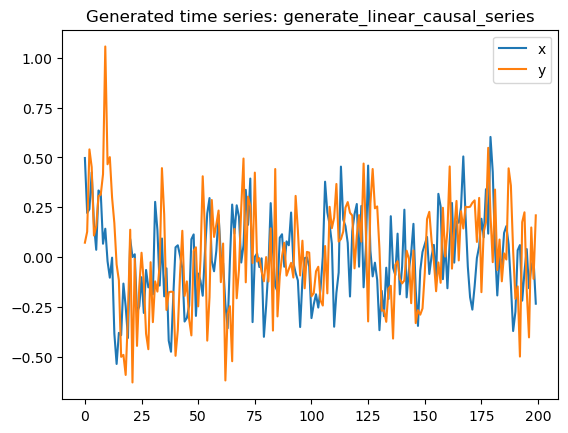

====== GRANGER CAUSALITY ANALYSIS ======

STEP 1: Checking stationarity of time series
-------------------------------------------
Series 'x': Stationary (p-value: 0.0000, ADF: -8.8195)
Series 'y': Stationary (p-value: 0.0000, ADF: -6.1793)

STEP 2: Making time series stationary
------------------------------------
All series are already stationary. No differencing applied.

STEP 3: Selecting optimal lag order
---------------------------------
Optimal lag selection by information criteria:
  AIC: 4
  BIC: 2
  FPE: 4
  HQIC: 2
Selected lag (HQIC): 2

STEP 4: Performing VAR analysis
-----------------------------

VAR Analysis Summary (lag order = 2):
----------------------------------------
Number of observations: 198
Log likelihood: 91.7289
AIC: -6.5013
BIC: -6.3352

STEP 5: Testing Granger causality
-------------------------------
Found 2 promising variable combinations:
  y → x
  x → y

Granger causality test results:
-----------------------------
y does NOT Granger cause x (min p-val

<Figure size 1200x600 with 0 Axes>

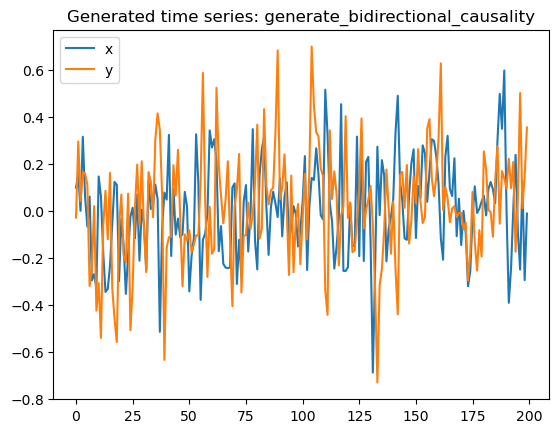

====== GRANGER CAUSALITY ANALYSIS ======

STEP 1: Checking stationarity of time series
-------------------------------------------
Series 'x': Stationary (p-value: 0.0000, ADF: -10.3497)
Series 'y': Stationary (p-value: 0.0000, ADF: -5.0527)

STEP 2: Making time series stationary
------------------------------------
All series are already stationary. No differencing applied.

STEP 3: Selecting optimal lag order
---------------------------------
Optimal lag selection by information criteria:
  AIC: 3
  BIC: 2
  FPE: 3
  HQIC: 3
Selected lag (HQIC): 2

STEP 4: Performing VAR analysis
-----------------------------

VAR Analysis Summary (lag order = 2):
----------------------------------------
Number of observations: 198
Log likelihood: 87.6610
AIC: -6.4602
BIC: -6.2941

STEP 5: Testing Granger causality
-------------------------------
Found 2 promising variable combinations:
  y → x
  x → y

Granger causality test results:
-----------------------------
y does NOT Granger cause x (min p-va

<Figure size 1200x600 with 0 Axes>

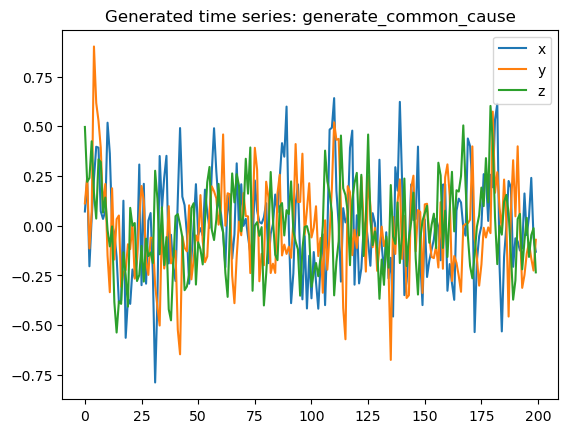

====== GRANGER CAUSALITY ANALYSIS ======

STEP 1: Checking stationarity of time series
-------------------------------------------
Series 'x': Stationary (p-value: 0.0000, ADF: -9.4137)
Series 'y': Stationary (p-value: 0.0000, ADF: -6.7918)
Series 'z': Stationary (p-value: 0.0000, ADF: -8.8195)

STEP 2: Making time series stationary
------------------------------------
All series are already stationary. No differencing applied.

STEP 3: Selecting optimal lag order
---------------------------------
Optimal lag selection by information criteria:
  AIC: 3
  BIC: 2
  FPE: 3
  HQIC: 3
Selected lag (HQIC): 2

STEP 4: Performing VAR analysis
-----------------------------

VAR Analysis Summary (lag order = 2):
----------------------------------------
Number of observations: 198
Log likelihood: 117.3817
AIC: -9.4872
BIC: -9.1384

STEP 5: Testing Granger causality
-------------------------------
Found 3 promising variable combinations:
  y → x
  z → y
  x → z

Granger causality test results:
---

<Figure size 1200x600 with 0 Axes>

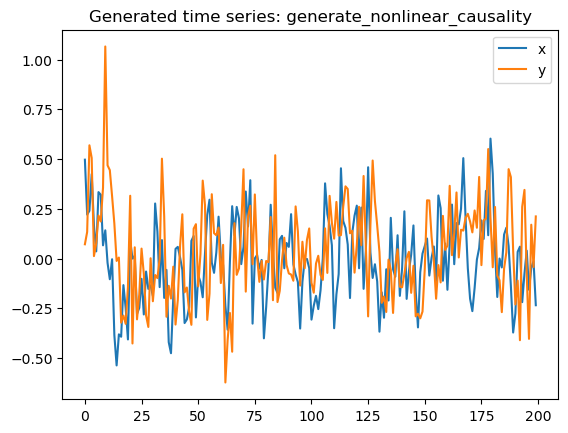

====== GRANGER CAUSALITY ANALYSIS ======

STEP 1: Checking stationarity of time series
-------------------------------------------
Series 'x': Stationary (p-value: 0.0000, ADF: -8.8195)
Series 'y': Stationary (p-value: 0.0000, ADF: -9.5037)

STEP 2: Making time series stationary
------------------------------------
All series are already stationary. No differencing applied.

STEP 3: Selecting optimal lag order
---------------------------------
Optimal lag selection by information criteria:
  AIC: 2
  BIC: 2
  FPE: 2
  HQIC: 2
Selected lag (HQIC): 2

STEP 4: Performing VAR analysis
-----------------------------

VAR Analysis Summary (lag order = 2):
----------------------------------------
Number of observations: 198
Log likelihood: 94.4843
AIC: -6.5291
BIC: -6.3631

STEP 5: Testing Granger causality
-------------------------------
Found 2 promising variable combinations:
  y → x
  x → y

Granger causality test results:
-----------------------------
y does NOT Granger cause x (min p-val

<Figure size 1200x600 with 0 Axes>

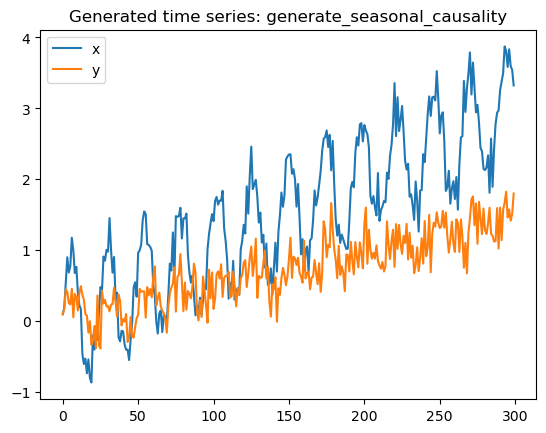

====== GRANGER CAUSALITY ANALYSIS ======

STEP 1: Checking stationarity of time series
-------------------------------------------
Series 'x': Non-stationary (p-value: 0.9101, ADF: -0.4001)
Series 'y': Non-stationary (p-value: 0.8815, ADF: -0.5518)

STEP 2: Making time series stationary
------------------------------------
Differencing applied:
  x: 1 difference(s)
  y: 1 difference(s)
Final data shape: (299, 2)

STEP 3: Selecting optimal lag order
---------------------------------
Optimal lag selection by information criteria:
  AIC: 10
  BIC: 10
  FPE: 10
  HQIC: 10
Selected lag (HQIC): 10

STEP 4: Performing VAR analysis
-----------------------------

VAR Analysis Summary (lag order = 10):
----------------------------------------
Number of observations: 289
Log likelihood: 42.2161
AIC: -5.6772
BIC: -5.1444

STEP 5: Testing Granger causality
-------------------------------
Found 2 promising variable combinations:
  y → x
  x → y

Granger causality test results:
----------------------

In [4]:
from jupyter_ipynb.Entropy_and_information.generate_variables import test_granger_with_generated_data,generate_linear_causal_series,generate_bidirectional_causality,generate_common_cause,generate_nonlinear_causality,generate_seasonal_causality

# 1. Linear causal relationship: X -> Y at lags 2 and 4
params = {'n': 200, 'lags': [2, 4], 'coeffs': [0.6, 0.3], 'noise_level': 0.2, 'seed': 42}
df1, results1 = test_granger_with_generated_data(generate_linear_causal_series, params)

# 2. Bidirectional causality: X <-> Y with different strengths
params = {
    'n': 200, 
    'xy_lags': [2], 'xy_coeffs': [0.5],  # X -> Y stronger
    'yx_lags': [3], 'yx_coeffs': [0.2],  # Y -> X weaker
    'seed': 42
}
df2, results2 = test_granger_with_generated_data(generate_bidirectional_causality, params)

# 3. Common cause: Z -> X, Z -> Y
params = {
    'n': 200,
    'xz_lags': [2], 'xz_coeffs': [0.5],
    'yz_lags': [3], 'yz_coeffs': [0.5],
    'seed': 42
}
df3, results3 = test_granger_with_generated_data(generate_common_cause, params)

# 4. Non-linear causality
params = {'n': 200, 'lag': 2, 'noise_level': 0.2, 'seed': 42}
df4, results4 = test_granger_with_generated_data(generate_nonlinear_causality, params)

# 5. Seasonal causality
params = {
    'n': 300, 'period': 24, 'lag': 6, 
    'seasonal_strength': 0.8, 'causal_strength': 0.5, 
    'seed': 42
}
df5, results5 = test_granger_with_generated_data(generate_seasonal_causality, params)

====== GRANGER CAUSALITY ANALYSIS ======

STEP 1: Checking stationarity of time series
-------------------------------------------
Series 'x': Stationary (p-value: 0.0000, ADF: -6.1698)
Series 'y': Non-stationary (p-value: 0.0851, ADF: -2.6397)
Series 'z': Stationary (p-value: 0.0000, ADF: -7.6587)

STEP 2: Making time series stationary
------------------------------------
Differencing applied:
  x: 0 difference(s)
  y: 1 difference(s)
  z: 0 difference(s)
Final data shape: (99, 3)

STEP 3: Selecting optimal lag order
---------------------------------
Optimal lag selection by information criteria:
  AIC: 10
  BIC: 8
  FPE: 10
  HQIC: 10
Selected lag (BIC): 8

STEP 4: Performing VAR analysis
-----------------------------

VAR Analysis Summary (lag order = 8):
----------------------------------------
Number of observations: 91
Log likelihood: 432.9173
AIC: -16.3799
BIC: -14.3106

STEP 5: Testing Granger causality
-------------------------------
Found 5 promising variable combinations:
  

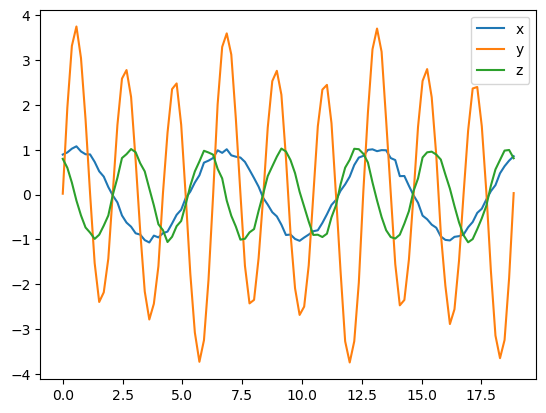

In [2]:
t,x,y,z =  load_sinusoidales_sum(n=100,T=6*np.pi,lag=np.pi/3,noise=True,seed=42,alpha= [0.5,0.5,3])
df = pd.DataFrame({'x': x,'y': y,'z': z},index = t)
df.plot()

gc = GrangerCausalityAnalysis(df)
results = gc.full_analysis()

====== GRANGER CAUSALITY ANALYSIS ======

STEP 1: Checking stationarity of time series
-------------------------------------------
Series 'Metro': Stationary (p-value: 0.0000, ADF: -11.8327)
Series 'Bar': Stationary (p-value: 0.0000, ADF: -10.2509)

STEP 2: Making time series stationary
------------------------------------
All series are already stationary. No differencing applied.

STEP 3: Selecting optimal lag order
---------------------------------
Optimal lag selection by information criteria:
  AIC: 1
  BIC: 1
  FPE: 1
  HQIC: 1
Selected lag (BIC): 1

STEP 4: Performing VAR analysis
-----------------------------

VAR Analysis Summary (lag order = 1):
----------------------------------------
Number of observations: 719
Log likelihood: -4852.0750
AIC: 7.8377
BIC: 7.8759

STEP 5: Testing Granger causality
-------------------------------
Found 1 promising variable combinations:
  Metro → Bar

Granger causality test results:
-----------------------------
Metro Granger causes Bar (min p

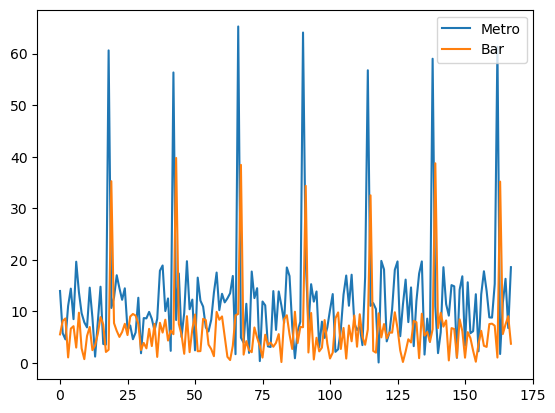

In [8]:
X_metro,Y_alcool = load_variables_subway_bar()
df = pd.DataFrame({'Metro': X_metro,'Bar': Y_alcool})
df.iloc[:24*7].plot()

gc = GrangerCausalityAnalysis(df)
results = gc.full_analysis()

====== GRANGER CAUSALITY ANALYSIS ======

STEP 1: Checking stationarity of time series
-------------------------------------------
Series 'X_lagged_peak': Stationary (p-value: 0.0000, ADF: -17.7437)
Series 'Y': Stationary (p-value: 0.0000, ADF: -12.5607)

STEP 2: Making time series stationary
------------------------------------
All series are already stationary. No differencing applied.

STEP 3: Selecting optimal lag order
---------------------------------
Optimal lag selection by information criteria:
  AIC: 5
  BIC: 0
  FPE: 5
  HQIC: 5
Selected lag (BIC): 5

STEP 4: Performing VAR analysis
-----------------------------

VAR Analysis Summary (lag order = 5):
----------------------------------------
Number of observations: 715
Log likelihood: -5092.2075
AIC: 8.6297
BIC: 8.7704

STEP 5: Testing Granger causality
-------------------------------
Found 2 promising variable combinations:
  Y → X_lagged_peak
  X_lagged_peak → Y

Granger causality test results:
-----------------------------

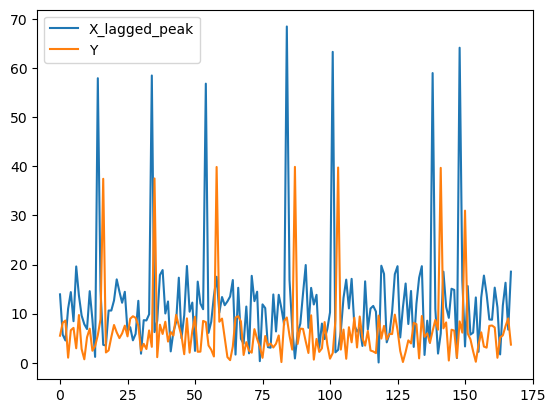

In [9]:
X_lagged_peak,Y_random_peak = load_variables_with_lagged_peak(seed=123,max_lag = 6, same_amplitude_through_lag = True,same_amplitude_per_lag=False,random_amplitude=False)
df = pd.DataFrame({'X_lagged_peak': X_lagged_peak,'Y': Y_random_peak})
df.iloc[:24*7].plot()

gc = GrangerCausalityAnalysis(df)
results = gc.full_analysis(max_lag=10, max_diff=2, criterion='AIC')

====== GRANGER CAUSALITY ANALYSIS ======

STEP 1: Checking stationarity of time series
-------------------------------------------
Series 'X_lagged_peak': Stationary (p-value: 0.0000, ADF: -9.5870)
Series 'Y': Stationary (p-value: 0.0000, ADF: -11.9586)

STEP 2: Making time series stationary
------------------------------------
All series are already stationary. No differencing applied.

STEP 3: Selecting optimal lag order
---------------------------------
Optimal lag selection by information criteria:
  AIC: 7
  BIC: 4
  FPE: 7
  HQIC: 5
Selected lag (BIC): 7

STEP 4: Performing VAR analysis
-----------------------------

VAR Analysis Summary (lag order = 7):
----------------------------------------
Number of observations: 713
Log likelihood: -5690.3641
AIC: 10.3701
BIC: 10.5624

STEP 5: Testing Granger causality
-------------------------------
Found 2 promising variable combinations:
  Y → X_lagged_peak
  X_lagged_peak → Y

Granger causality test results:
----------------------------

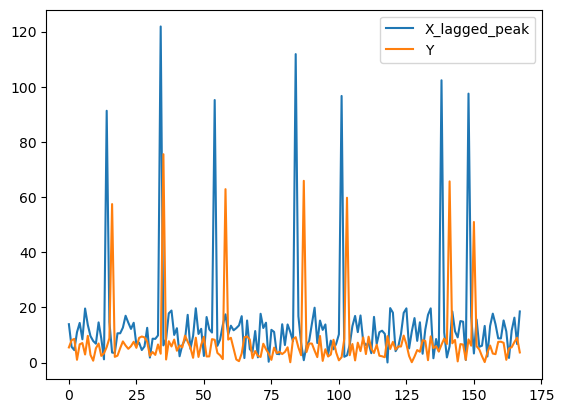

In [10]:
X_lagged_peak,Y_random_peak = load_variables_with_lagged_peak(seed=123,max_lag = 6,same_amplitude_per_lag=True)
df = pd.DataFrame({'X_lagged_peak': X_lagged_peak,'Y': Y_random_peak})
df.iloc[:24*7].plot()

gc = GrangerCausalityAnalysis(df)
results = gc.full_analysis(max_lag=10, max_diff=2, criterion='AIC')

====== GRANGER CAUSALITY ANALYSIS ======

STEP 1: Checking stationarity of time series
-------------------------------------------
Series 'X_lagged_peak': Stationary (p-value: 0.0000, ADF: -29.1092)
Series 'Y': Stationary (p-value: 0.0000, ADF: -10.3047)

STEP 2: Making time series stationary
------------------------------------
All series are already stationary. No differencing applied.

STEP 3: Selecting optimal lag order
---------------------------------
Optimal lag selection by information criteria:
  AIC: 5
  BIC: 1
  FPE: 5
  HQIC: 5
Selected lag (BIC): 5

STEP 4: Performing VAR analysis
-----------------------------

VAR Analysis Summary (lag order = 5):
----------------------------------------
Number of observations: 715
Log likelihood: -5782.6921
AIC: 10.5611
BIC: 10.7018

STEP 5: Testing Granger causality
-------------------------------
Found 2 promising variable combinations:
  Y → X_lagged_peak
  X_lagged_peak → Y

Granger causality test results:
---------------------------

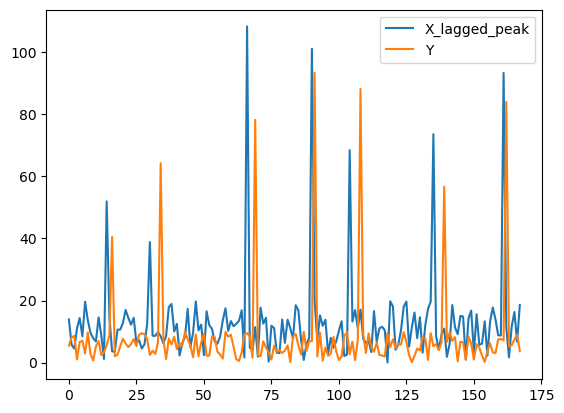

In [11]:
X_lagged_peak,Y_random_peak = load_variables_with_lagged_peak(seed=123,max_lag = 6,random_amplitude=True)
df = pd.DataFrame({'X_lagged_peak': X_lagged_peak,'Y': Y_random_peak})
df.iloc[:24*7].plot()

gc = GrangerCausalityAnalysis(df)
results = gc.full_analysis(max_lag=10, max_diff=2, criterion='AIC')

In [ ]:
import pandas as pd
